In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import shapefile as shp
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import sys
sys.path.append('../scripts')
from preprocess_script import count_outliers

In [2]:
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("Outlier Analysis")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "9g") 
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)
spark.sparkContext.setLogLevel("OFF")

24/09/11 09:52:07 WARN Utils: Your hostname, LAPTOP-406UJ3L3 resolves to a loopback address: 127.0.1.1; using 172.22.101.212 instead (on interface eth0)
24/09/11 09:52:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/11 09:52:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## 1. Merchant
1. merchant fraud probability falls beween 0 and 1 and seem reasonable. So no further outlier analysis.
2. further outlier analysis on merchant data joined with aggregated transaction data.

In [5]:
merchant = spark.read.parquet("../data/curated/part_1/clean_merchant.parquet")
print(f"Number of rows: {merchant.count()}")
merchant.printSchema()
merchant.limit(5)

Number of rows: 4026
root
 |-- merchant_abn: long (nullable = true)
 |-- name: string (nullable = true)
 |-- goods: string (nullable = true)
 |-- revenue_level: string (nullable = true)
 |-- take_rate: double (nullable = true)
 |-- sum(dollar_value): double (nullable = true)
 |-- count(dollar_value): long (nullable = true)
 |-- log_ratio: double (nullable = true)
 |-- unscaled_earning: double (nullable = true)



merchant_abn,name,goods,revenue_level,take_rate,sum(dollar_value),count(dollar_value),log_ratio,unscaled_earning
12516851436,Mollis Corp.,"watch, clock, and...",a,6.71,32325.484349738046,210,5.036503656560932,2169.0399998674225
15613631617,Ante Industries,motor vehicle sup...,e,0.35,543030.5313328261,1785,5.717747130253923,1900.6068596648913
19839532017,Pellentesque Habi...,"cable, satellite,...",b,4.94,113982.0,726,5.056245805348308,5630.710800000001
34440496342,Mauris Nulla Inte...,"opticians, optica...",c,2.85,19425.358828709985,215,4.503696619458033,553.6227266182345
35344855546,Quis Tristique Ac...,"watch, clock, and...",c,2.92,134737.25046268434,1522,4.483301329640816,3934.327713510383


In [40]:
for col in ['take_rate', 'sum(dollar_value)', 'count(dollar_value)', 'log_ratio', 'unscaled_earning']:
    print(f"{merchant.agg({col: 'max'})}")
    print(f"{merchant.agg({col: 'min'})}")

+--------------+
|max(take_rate)|
+--------------+
|           7.0|
+--------------+

+--------------+
|min(take_rate)|
+--------------+
|           0.1|
+--------------+



0 outliers outside of bounds (-4.31224458286971, 13.262244582869709)
+----------------------+
|max(sum(dollar_value))|
+----------------------+
|     9857402.328111365|
+----------------------+

+----------------------+
|min(sum(dollar_value))|
+----------------------+
|    10064.933918748828|
+----------------------+



141 outliers outside of bounds (-1292984.3547945288, 1924208.586622729)
+------------------------+
|max(count(dollar_value))|
+------------------------+
|                  289513|
+------------------------+

+------------------------+
|min(count(dollar_value))|
+------------------------+
|                       1|
+------------------------+

441 outliers outside of bounds (-4284.395260103123, 6306.395260103123)
+------------------+
|    max(log_ratio)|
+------------------+
|10.856623824531193|
+------------------+

+-----------------+
|   min(log_ratio)|
+-----------------+
|2.026606758081709|
+-----------------+

0 outliers outside of bounds (0.2806870832089441, 11.13681478306458)
+---------------------+
|max(unscaled_earning)|
+---------------------+
|     663870.290228123|
+---------------------+

+---------------------+
|min(unscaled_earning)|
+---------------------+
|   12.313488406755763|
+---------------------+

283 outliers outside of bounds (-47541.58876830382, 71037.225684429

Min-max values for take_rate, log_ratio and unscaled_earning seem reasonable. Further inspect distribution by plotting.

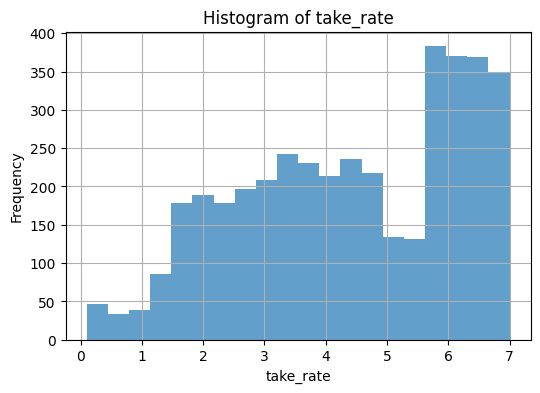

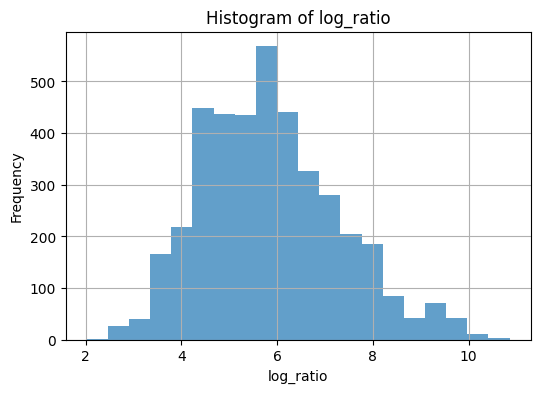

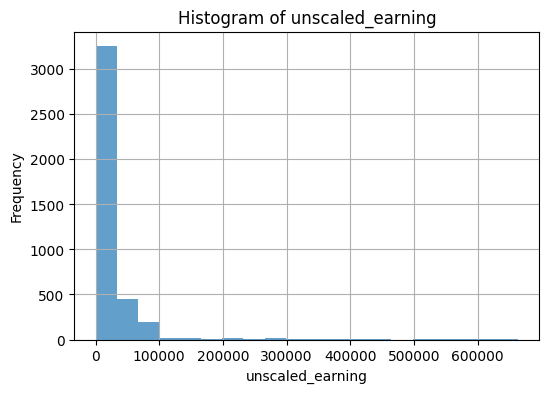

In [35]:
# Convert Spark DataFrame to Pandas DataFrame (you need to adjust this to fit your actual DataFrame)
merchant_pd = merchant.select('take_rate', 'log_ratio', 'unscaled_earning').toPandas()

# Plot histograms for the selected columns
for col in ['take_rate', 'log_ratio', 'unscaled_earning']:
    plt.figure(figsize=(6, 4))
    plt.hist(merchant_pd[col], bins=20, alpha=0.7)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

unscaled_earning is non-normal, transform to make it normal before applying the log IQR outlier removal rule.

In [41]:
merchant = merchant.withColumn("log(unscaled_earning)", F.log(F.col("unscaled_earning")))
merchant.limit(5)

merchant_abn,name,goods,revenue_level,take_rate,sum(dollar_value),count(dollar_value),log_ratio,unscaled_earning,log(unscaled_earning)
12516851436,Mollis Corp.,"watch, clock, and...",a,6.71,32325.484349738053,210,5.036503656560932,2169.0399998674234,7.682039952273899
15613631617,Ante Industries,motor vehicle sup...,e,0.35,543030.531332826,1785,5.717747130253923,1900.6068596648909,7.549928513980894
19839532017,Pellentesque Habi...,"cable, satellite,...",b,4.94,113982.0,726,5.056245805348308,5630.710800000001,8.635990965384844
34440496342,Mauris Nulla Inte...,"opticians, optica...",c,2.85,19425.35882870998,215,4.503696619458033,553.6227266182344,6.3164834558781635
35344855546,Quis Tristique Ac...,"watch, clock, and...",c,2.92,134737.25046268434,1522,4.483301329640816,3934.327713510383,8.277495298354546


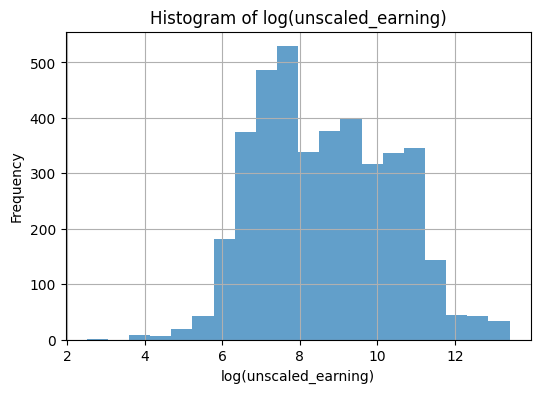

In [43]:
merchant_pd = merchant.select('take_rate', 'log_ratio', 'log(unscaled_earning)').toPandas()

col = "log(unscaled_earning)"
plt.figure(figsize=(6, 4))
plt.hist(merchant_pd[col], bins=20, alpha=0.7)
plt.title(f'Histogram of {col}')
plt.xlabel(col)
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [44]:
for col in ['take_rate', 'log_ratio', 'log(unscaled_earning)']:
    count_outliers(merchant, col)

0 outliers outside of bounds (-4.31224458286971, 13.262244582869709)
0 outliers outside of bounds (0.2806870832089441, 11.13681478306458)
0 outliers outside of bounds (0.819373778004798, 16.466158639189484)


### Conclusion
No confirmed outliers in joined merchant and aggregated transaction data. No removal of records.

## SA2 Datasets

In [ ]:
median_mortgage = pd.read_csv("../data/curated/sa2_dataset/C21_G02_SA2_clean.csv")
median_mortgage.shape

(19722, 4)

In [ ]:
median_mortgage.head(5)

,monthly_mortgage_median,region_id,state,obs_value
0,1,103031075,1,0.0
1,1,108051168,1,53.0
2,1,119031370,1,40.0
3,1,123011433,1,42.0
4,1,123031448,1,38.0


In [61]:
print(median_mortgage['monthly_mortgage_median'].min())
print(median_mortgage['monthly_mortgage_median'].max())

# Print the sorted unique values
print("-----------")
unique_values = sorted(median_mortgage['monthly_mortgage_median'].unique())
for unique_val in unique_values:
    print(unique_val)

1
8
-----------
1
2
3
4
5
6
7
8


In [ ]:
household_income_weekly = pd.read_csv("../data/curated/sa2_dataset/C21_G33_SA2_clean.csv")
household_income_weekly.shape

# https://www.abs.gov.au/census/guide-census-data/census-dictionary/2021/variables-topic/income-and-work/total-household-income-weekly-hind
# https://www.abs.gov.au/census/guide-census-data/census-dictionary/2021/variables-topic/household-and-families/household-composition-hhcd

(147780, 5)

In [ ]:
household_income_weekly.head(5)


,household_income_weekly,household_composition,region_id,state,obs_value
0,7,1_2,101021008,1,94
1,7,_T,101021611,1,124
2,16,3,101041025,1,0
3,16,1_2,101051540,1,174
4,5,_T,102011034,1,302


In [50]:
print(household_income_weekly['household_income_weekly'].min())
print(household_income_weekly['household_income_weekly'].max())

# Print the sorted unique values
print(sorted(household_income_weekly['household_income_weekly'].unique()))


1
_T
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '2', '3', '4', '5', '6', '7', '8', '9', '_N', '_T']


In [ ]:
monthly_mortgage_repayments_ranges = pd.read_csv("../data/curated/sa2_dataset/C21_G38_SA2_clean.csv")
monthly_mortgage_repayments_ranges.shape
# https://www.abs.gov.au/census/guide-census-data/census-dictionary/2021/variables-topic/housing/mortgage-repayments-monthly-ranges-mrerd

(192114, 5)

In [ ]:
monthly_mortgage_repayments_ranges.head(5)

,monthly_mortgage_repayments_ranges,dwelling_structure,region_id,state,obs_value
0,7,11,101021008,1,143
1,7,_T,101021611,1,251
2,11,_N,102011030,1,0
3,5,_T,102011034,1,32
4,4,11,102011035,1,20


In [62]:
print(monthly_mortgage_repayments_ranges['monthly_mortgage_repayments_ranges'].min())
print(monthly_mortgage_repayments_ranges['monthly_mortgage_repayments_ranges'].max())

# Print the sorted unique values
print(sorted(monthly_mortgage_repayments_ranges['monthly_mortgage_repayments_ranges'].unique()))


1
_T
['1', '10', '11', '2', '3', '4', '5', '6', '7', '8', '9', '_N', '_T']


In [ ]:
weekly_rent_range = pd.read_csv("../data/curated/sa2_dataset/C21_G40_SA2_clean.csv")
weekly_rent_range.shape

# https://www.abs.gov.au/census/guide-census-data/census-dictionary/2021/variables-topic/housing/rent-weekly-ranges-rntrd

(275856, 5)

In [ ]:
weekly_rent_range.head(5)

,weekly_rent_range,landlord_type,region_id,state,obs_value
0,7,1,101021008,1,22
1,13,_O,101021009,1,0
2,7,_T,101021611,1,52
3,4,1,102011035,1,0
4,14,2,102021048,1,0


In [63]:
print(weekly_rent_range['weekly_rent_range'].min())
print(weekly_rent_range['weekly_rent_range'].max())

# Print the sorted unique values
print(sorted(weekly_rent_range['weekly_rent_range'].unique()))


1
_T
['1', '10', '11', '12', '13', '14', '2', '3', '4', '5', '6', '7', '8', '9', '_N', '_T']


Conclusion: External datasets have categories instead of numeric values. No outlier analysis needed.